In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import datetime


In [3]:
ticker = "AJBU.SI"
start_date = "2015-01-01"
end_date = "2025-03-17"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AJBU.SI,AJBU.SI,AJBU.SI,AJBU.SI,AJBU.SI,AJBU.SI
Date,,,,,,
2015-01-02,0.757441,0.941787,0.941787,0.936957,0.936957,2358335
2015-01-05,0.753557,0.936957,0.941787,0.932127,0.941787,3638959
2015-01-06,0.753557,0.936957,0.941787,0.932127,0.932127,2221680
2015-01-07,0.753557,0.936957,0.936957,0.932127,0.936957,4757046
2015-01-08,0.753557,0.936957,0.936957,0.932127,0.936957,2782794
...,...,...,...,...,...,...
2025-03-10,2.070000,2.070000,2.100000,2.060000,2.060000,4950600
2025-03-11,2.050000,2.050000,2.070000,2.020000,2.060000,9741600


In [5]:
df.dropna(inplace=True)


In [6]:
df.sort_index(inplace=True)


In [7]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [8]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.757441,0.941787,0.941787,0.936957,0.936957,2358335
2015-01-05,0.753557,0.936957,0.941787,0.932127,0.941787,3638959
2015-01-06,0.753557,0.936957,0.941787,0.932127,0.932127,2221680
2015-01-07,0.753557,0.936957,0.936957,0.932127,0.936957,4757046
2015-01-08,0.753557,0.936957,0.936957,0.932127,0.936957,2782794
...,...,...,...,...,...,...
2025-03-10,2.070000,2.070000,2.100000,2.060000,2.060000,4950600
2025-03-11,2.050000,2.050000,2.070000,2.020000,2.060000,9741600
2025-03-12,2.150000,2.150000,2.170000,2.030000,2.040000,21756500


In [9]:

df = df.rename(columns={'Close': 'GT'})
df = df[['GT']]

df

Price,GT
Date,
2015-01-02,0.941787
2015-01-05,0.936957
2015-01-06,0.936957
2015-01-07,0.936957
2015-01-08,0.936957
...,...
2025-03-10,2.070000
2025-03-11,2.050000
2025-03-12,2.150000


In [10]:
print(df['GT'].dtypes)
print(df['GT'].describe())


float64
count    2561.000000
mean        1.765706
std         0.571261
min         0.927298
25%         1.261852
50%         1.760000
75%         2.190000
max         3.060000
Name: GT, dtype: float64


### Visualize Data

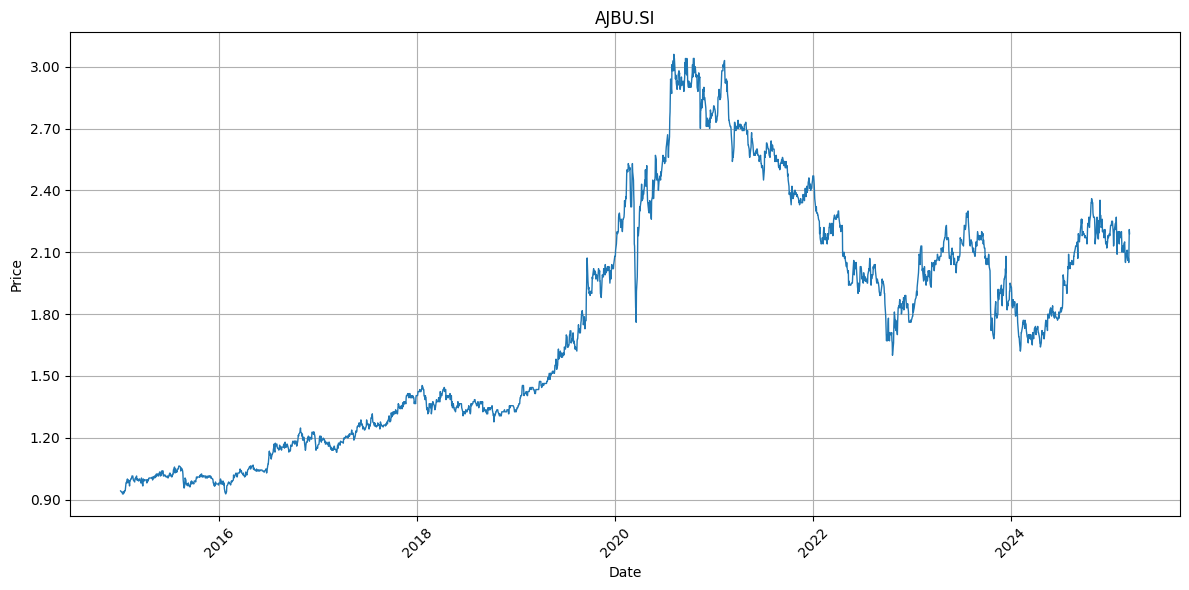

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['GT'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AJBU.SI')

# Format y-axis ticks to 2 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Limit to ~8 y-axis ticks
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8)) 

# Rotate x-axis ticks to avoid overlap
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Standardize data 

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df['GT'].values.reshape(-1,1))
scaled_prices

array([[0.00679373],
       [0.00452899],
       [0.00452899],
       ...,
       [0.57331129],
       [0.60144458],
       [0.59206682]], shape=(2561, 1))

## Construct datasets

In [13]:
MOVING_WINDOW = 60
all_x, all_y = [], []
for i in range(len(scaled_prices) - MOVING_WINDOW):
    all_x.append(scaled_prices[i:i+MOVING_WINDOW]) #first 60 price
    all_y.append(scaled_prices[i+MOVING_WINDOW]) #61st price

all_x = np.array(all_x)
all_y = np.array(all_y)

In [14]:
all_x.shape, all_y.shape

((2501, 60, 1), (2501, 1))

## Split dataset

In [15]:
DS_SPLIT = 0.8

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [16]:
train_x.shape

(2001, 60, 1)

In [17]:
train_y.shape

(2001, 1)

In [18]:
test_x.shape

(500, 60, 1)

In [19]:
test_y.shape

(500, 1)

## Construct Model

In [20]:
'''
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()
'''

'\nmodel = Sequential()\nmodel.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))\nmodel.add(LSTM(50, return_sequences=False))\nmodel.add(Dense(25))\nmodel.add(Dense(1))\n\nmodel.summary()\n'

In [21]:
'''
model.compile(optimizer='adam', loss='mean_squared_error')
'''

"\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n"

## Train Model

In [22]:
'''
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=200)

model.save('ajbu.keras') 
'''

"\ncallback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\nmodel.fit(train_x, train_y,\n          validation_split=0.2,\n          callbacks=[callback],\n          epochs=200)\n\nmodel.save('ajbu.keras') \n"

In [23]:
model = load_model('ajbu.keras')
preds = model.predict(test_x)
preds

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.5249914 ],
       [0.524001  ],
       [0.5215275 ],
       [0.51966804],
       [0.52232015],
       [0.5170625 ],
       [0.5078543 ],
       [0.52183616],
       [0.526466  ],
       [0.523364  ],
       [0.5210987 ],
       [0.52720094],
       [0.53021556],
       [0.5340643 ],
       [0.5419843 ],
       [0.54110616],
       [0.53579116],
       [0.5299202 ],
       [0.52826387],
       [0.53225124],
       [0.53813523],
       [0.54033345],
       [0.5403476 ],
       [0.5537188 ],
       [0.55565053],
       [0.55417997],
       [0.5562631 ],
       [0.5500681 ],
       [0.554228  ],
       [0.55700296],
       [0.5684322 ],
       [0.5798885 ],
       [0.5826402 ],
       [0.5886392 ],
       [0.5971958 ],
       [0.60653484],
       [0.59390587],
       [0.57636833],
       [0.5749114 ],
       [0.5777043 ],
       [0.58021295],
       [0.577917  ],
       [0.55899423],
       [0.5449132 ],
       [0.5354045 ],
       [0.5381039 ],
       [0.5381769 ],
       [0.531

In [24]:
preds = scaler.inverse_transform(preds) #convert back to original scale
preds

array([[2.0469482],
       [2.0448358],
       [2.0395608],
       [2.035595 ],
       [2.0412512],
       [2.030038 ],
       [2.0103998],
       [2.040219 ],
       [2.050093 ],
       [2.0434773],
       [2.0386462],
       [2.0516605],
       [2.0580897],
       [2.066298 ],
       [2.083189 ],
       [2.0813162],
       [2.0699809],
       [2.0574598],
       [2.0539274],
       [2.0624313],
       [2.07498  ],
       [2.0796683],
       [2.0796983],
       [2.108215 ],
       [2.112335 ],
       [2.1091986],
       [2.1136413],
       [2.1004293],
       [2.109301 ],
       [2.1152194],
       [2.1395946],
       [2.1640275],
       [2.169896 ],
       [2.18269  ],
       [2.2009387],
       [2.2208562],
       [2.193922 ],
       [2.15652  ],
       [2.1534126],
       [2.1593692],
       [2.1647193],
       [2.1598227],
       [2.119466 ],
       [2.0894353],
       [2.0691562],
       [2.0749133],
       [2.075069 ],
       [2.060982 ],
       [2.0480535],
       [2.0815494],


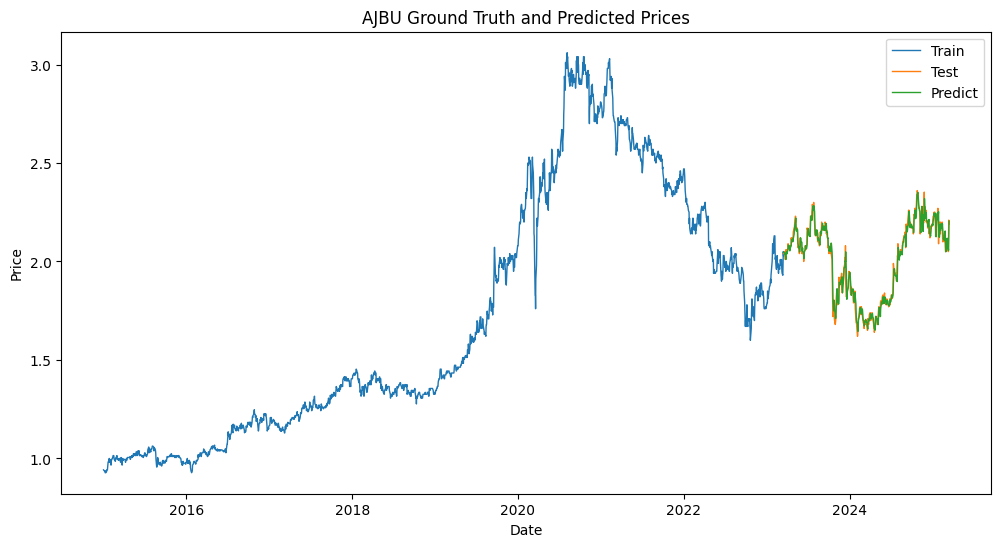

In [25]:
train_df = df[:train_ds_size+MOVING_WINDOW]
test_df = df[train_ds_size+MOVING_WINDOW:]
test_df = test_df.assign(Predict = preds)

plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_df["GT"], linewidth=1)
plt.plot(test_df["GT"], linewidth=1)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "Test", "Predict"])
plt.title('AJBU Ground Truth and Predicted Prices')
plt.show()

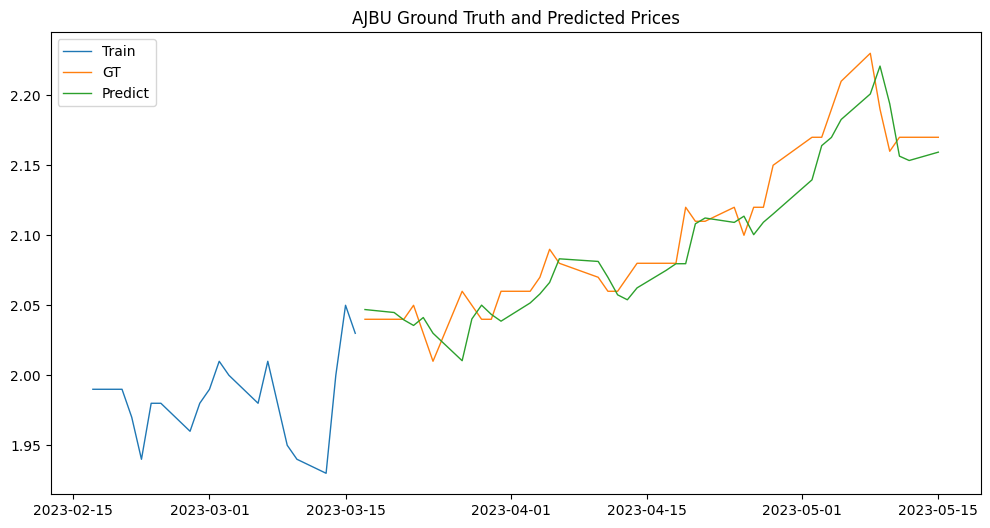

In [26]:
#zoom in
plt.figure(figsize=(12, 6))
plt.plot(train_df["GT"][-20:], linewidth=1)
plt.plot(test_df["GT"][:40], linewidth=1)
plt.plot(test_df["Predict"][:40], linewidth=1)
plt.legend(["Train", "GT", "Predict"])
plt.title("AJBU Ground Truth and Predicted Prices")
plt.show()

In [55]:
y_true = test_df["GT"]
y_pred = test_df["Predict"]

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.024030
Mean Squared Error (MSE): 0.001126
Root Mean Squared Error (RMSE): 0.033553
R-squared (R²): 0.969463


In [28]:
test_df

Price,GT,Predict
Date,,
2023-03-17,2.04,2.046948
2023-03-20,2.04,2.044836
2023-03-21,2.04,2.039561
2023-03-22,2.05,2.035595
2023-03-23,2.03,2.041251
...,...,...
2025-03-10,2.07,2.064664
2025-03-11,2.05,2.066155
2025-03-12,2.15,2.056223


### Comparing one day shift to lstm predicted result

In [51]:
test_df['GT_tmr'] = test_df['GT'].shift(1)
test_df.dropna(subset=['GT_tmr'], inplace=True)

test_df

Price,GT,Predict,GT_tmr
Date,,,
2023-03-20,2.04,2.044836,2.04
2023-03-21,2.04,2.039561,2.04
2023-03-22,2.05,2.035595,2.04
2023-03-23,2.03,2.041251,2.05
2023-03-24,2.01,2.030038,2.03
...,...,...,...
2025-03-05,2.11,2.109934,2.10
2025-03-06,2.07,2.117965,2.11
2025-03-07,2.06,2.087545,2.07


In [53]:
results = {}

# Loop through the prediction columns
for col in ["Predict", "GT_tmr"]:
    y_true = test_df["GT"]
    y_pred = test_df[col]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results[col] = [mae, mse, rmse, r2]

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R2"])
print(metrics_df)

       Predict    GT_tmr
MAE   0.024030  0.022387
MSE   0.001126  0.001029
RMSE  0.033553  0.032072
R2    0.969463  0.972098


## Next-Day Predictive Trading Strategy

In [29]:
# Parameters
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.1  # 10%
capital = initial_capital
position = None  # Current position: 'long', 'short', or None
entry_price = 0  
equity = initial_capital  
trade_log = [] 

# Iterate through the DataFrame
for i in range(1, len(test_df) - 1): 
    current_price = test_df['GT'].iloc[i]  
    next_predicted_price = test_df['Predict'].iloc[i + 1]  
    date = test_df.index[i]  

    # Check if a position is active
    if position == 'long':
        # Check for stop-loss or trend reversal
        if current_price <= entry_price * (1 - stop_loss) or next_predicted_price < current_price:
            # Close long position
            profit = (current_price - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Long', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    elif position == 'short':
        # Check for stop-loss or trend reversal
        if current_price >= entry_price * (1 + stop_loss) or next_predicted_price > current_price:
            # Close short position
            profit = (entry_price - current_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Short', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    # If no position is active, check for entry signals
    if position is None:
        if next_predicted_price > current_price:
            # Open long position
            entry_price = current_price
            position = 'long'
            trade_log.append({'Date': date, 'Action': 'Open Long', 'Price': current_price, 'Profit': 0, 'Equity': equity})
        elif next_predicted_price < current_price:
            # Open short position
            entry_price = current_price
            position = 'short'
            trade_log.append({'Date': date, 'Action': 'Open Short', 'Price': current_price, 'Profit': 0, 'Equity': equity})


trade_log_df = pd.DataFrame(trade_log)

# Calculate metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Close')] 
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum() 
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()  
net_profit = gross_profit + gross_loss  

# Buy-and-Hold Return
initial_price = test_df['GT'].iloc[0] 
final_price = test_df['GT'].iloc[-1]  
buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100  

# Display results
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")

# Display the trade log
print(trade_log_df)

# Final equity
print(f"Final Equity: ${equity:.2f}")

Gross Profit: $13594.45
Gross Loss: $-12888.36
Net Profit: $706.09
Buy-and-Hold Return: 7.35%
          Date       Action  Price      Profit        Equity
0   2023-03-20   Open Short   2.04    0.000000  10000.000000
1   2023-03-23  Close Short   2.03   39.215650  10039.215650
2   2023-03-23    Open Long   2.03    0.000000  10039.215650
3   2023-03-27   Close Long   2.06  118.226490  10157.442140
4   2023-03-27   Open Short   2.06    0.000000  10157.442140
..         ...          ...    ...         ...           ...
402 2025-03-10   Open Short   2.07    0.000000  10238.549890
403 2025-03-11  Close Short   2.05   77.294615  10315.844505
404 2025-03-11    Open Long   2.05    0.000000  10315.844505
405 2025-03-12   Close Long   2.15  390.244470  10706.088975
406 2025-03-12   Open Short   2.15    0.000000  10706.088975

[407 rows x 5 columns]
Final Equity: $10706.09


In [30]:
import plotly.graph_objects as go

# Extract series
dates = test_df.index
gt = test_df['GT']
predict = test_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Open Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Open Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Close Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Close Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()


## Append News Analysis Result

In [31]:
sentiment_df = pd.read_csv('../news_analysis_code/ajbu_news_data.csv', usecols=['date', 'sentiment', 'sentiment_score'])
sentiment_df.columns = ['Date', 'Sentiment', 'Sentiment Score']
sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2025-03-19,neutral,0.517661
1,2025-03-18,neutral,0.652589
2,2025-03-14,neutral,0.938237
3,2025-03-18,positive,0.758177
4,2025-02-19,neutral,0.945785


In [32]:
# rearrange the date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Keep only the row with the highest sentiment score
sentiment_df = sentiment_df.loc[sentiment_df.groupby('Date')['Sentiment Score'].idxmax()].reset_index(drop=True)

sentiment_df.head()


,Date,Sentiment,Sentiment Score
0,2018-05-07,neutral,0.524378
1,2018-05-08,neutral,0.917020
2,2018-06-13,neutral,0.870323
3,2019-07-18,negative,0.930278
4,2019-09-16,neutral,0.925400


In [33]:
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace({
    'neutral': 0,
    'positive': 1,
    'negative': -1
})

sentiment_df.head()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_10524\1101630648.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Date,Sentiment,Sentiment Score
0,2018-05-07,0,0.524378
1,2018-05-08,0,0.917020
2,2018-06-13,0,0.870323
3,2019-07-18,-1,0.930278
4,2019-09-16,0,0.925400


In [34]:
sentiment_df.dtypes

Date               datetime64[ns]
Sentiment                   int64
Sentiment Score           float64
dtype: object

In [35]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index('Date')

In [36]:
#keep only matching dates
merged_df = pd.merge(test_df, sentiment_df, on='Date', how='left')
merged_df.head()

,GT,Predict,Sentiment,Sentiment Score
Date,,,,
2023-03-17,2.04,2.046948,NaN,NaN
2023-03-20,2.04,2.044836,NaN,NaN
2023-03-21,2.04,2.039561,NaN,NaN
2023-03-22,2.05,2.035595,NaN,NaN
2023-03-23,2.03,2.041251,NaN,NaN


In [37]:
merged_df[50:80]

,GT,Predict,Sentiment,Sentiment Score
Date,,,,
2023-05-30,2.10,2.120196,NaN,NaN
2023-05-31,2.09,2.116070,0.0,0.912532
2023-06-01,2.10,2.099052,0.0,0.912532
2023-06-05,2.04,2.097659,0.0,0.933211
2023-06-06,2.07,2.054198,0.0,0.943190
2023-06-07,2.07,2.058727,0.0,0.808271
2023-06-08,2.04,2.068015,NaN,NaN
2023-06-09,2.04,2.051063,NaN,NaN
2023-06-12,2.04,2.043280,NaN,NaN


In [38]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-03-17 to 2025-03-14
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GT               500 non-null    float64
 1   Predict          500 non-null    float32
 2   Sentiment        98 non-null     float64
 3   Sentiment Score  98 non-null     float64
dtypes: float32(1), float64(3)
memory usage: 17.6 KB


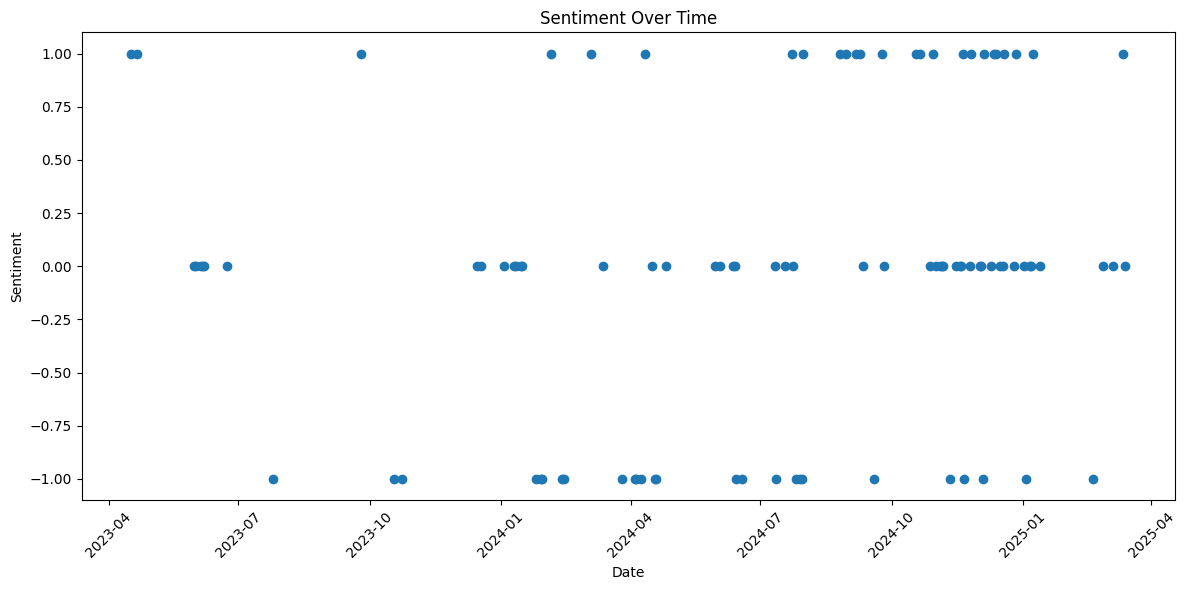

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Sentiment'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

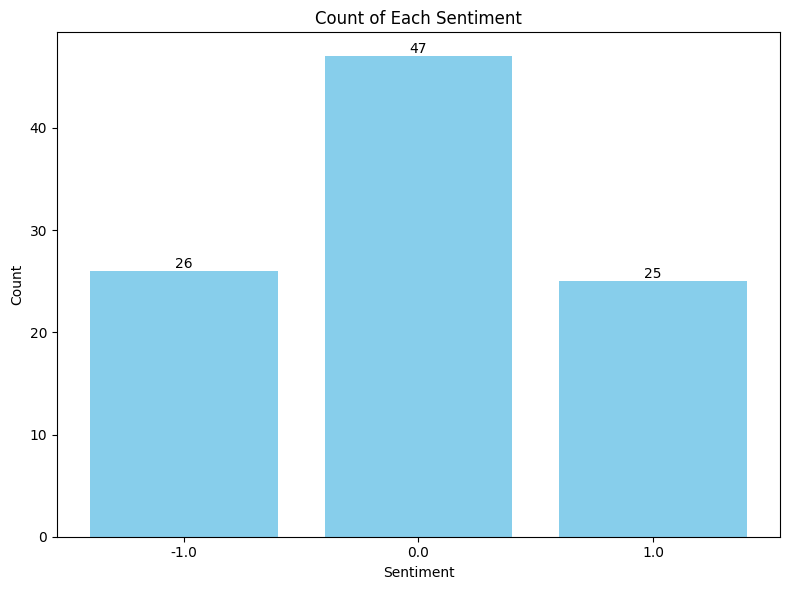

In [40]:
sentiment_counts = merged_df['Sentiment'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [41]:
nan_count = merged_df['Sentiment'].isna().sum()
nan_count

np.int64(402)

In [42]:
merged_df

,GT,Predict,Sentiment,Sentiment Score
Date,,,,
2023-03-17,2.04,2.046948,NaN,NaN
2023-03-20,2.04,2.044836,NaN,NaN
2023-03-21,2.04,2.039561,NaN,NaN
2023-03-22,2.05,2.035595,NaN,NaN
2023-03-23,2.03,2.041251,NaN,NaN
...,...,...,...,...
2025-03-10,2.07,2.064664,NaN,NaN
2025-03-11,2.05,2.066155,NaN,NaN
2025-03-12,2.15,2.056223,1.0,0.862051


## News-Driven Next-Day Predictive Trading Strategy

In [43]:
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.2

capital = initial_capital
equity = initial_capital
trade_log = []
position = None
entry_price = None

i = 0
while i < len(test_df):
    # Forced exit condition on March 14, 2025
    if merged_df.index[i] == pd.Timestamp("2025-03-14"):
        if position is not None:
            exec_price = test_df['GT'].iloc[i]
            if position == 'long':
                profit = (exec_price - entry_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Long',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
            elif position == 'short':
                profit = (entry_price - exec_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Short',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
        break

    signal_price = merged_df['GT'].iloc[i]
    predicted_price = merged_df['Predict'].iloc[i]

    # Entry signals (same day)
    if position is None:
        if predicted_price > signal_price and (merged_df['Sentiment'].iloc[i] in [1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'long'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Long',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        elif predicted_price < signal_price and (merged_df['Sentiment'].iloc[i] in [-1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'short'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Short',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        i += 1
        continue

    # Exit conditions (same day)
    current_gt = merged_df['GT'].iloc[i]
    if position == 'long':
        if predicted_price < current_gt or current_gt <= entry_price * (1 - stop_loss) or merged_df['Sentiment'].iloc[i] == -1:
            profit = (current_gt - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Long',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    elif position == 'short':
        if predicted_price > current_gt or current_gt >= entry_price * (1 + stop_loss) or merged_df['Sentiment'].iloc[i] == 1:
            profit = (entry_price - current_gt) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Short',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    i += 1

# Create DataFrame from trade log
trade_log_df = pd.DataFrame(trade_log)

# Summary metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Exit')]
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()
net_profit = gross_profit + gross_loss
buy_and_hold_return = ((test_df['GT'].iloc[-1] - test_df['GT'].iloc[0]) / test_df['GT'].iloc[0]) * 100

print(f"\n--- Strategy Summary ---")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")
print(f"Final Equity: ${equity:.2f}")
print("\nTrade Log:")
print(trade_log_df)



--- Strategy Summary ---
Gross Profit: $11782.75
Gross Loss: $-7065.61
Net Profit: $4717.13
Buy-and-Hold Return: 7.35%
Final Equity: $14644.73

Trade Log:
          Date             Action  Price      Profit        Equity
0   2023-03-17         Enter Long   2.04    0.000000  10000.000000
1   2023-03-21          Exit Long   2.04    0.000000  10000.000000
2   2023-03-22        Enter Short   2.05    0.000000  10000.000000
3   2023-03-23         Exit Short   2.03   78.048708  10078.048708
4   2023-03-24         Enter Long   2.01    0.000000  10078.048708
..         ...                ...    ...         ...           ...
305 2025-03-10          Exit Long   2.07   38.834915  14254.490126
306 2025-03-11         Enter Long   2.05    0.000000  14254.490126
307 2025-03-12          Exit Long   2.15  390.244470  14644.734595
308 2025-03-13        Enter Short   2.21    0.000000  14644.734595
309 2025-03-14  Forced Exit Short   2.19   72.398120  14644.734595

[310 rows x 5 columns]


In [44]:
# Extract series
dates = merged_df.index
gt = merged_df['GT']
predict = merged_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Enter Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Enter Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Exit Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Exit Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='News-Driven Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()
